In [1]:
import tensorflow as tf
import numpy as np
import random
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Nadam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
#from tqdm import tqdm
import time
import sys
import matplotlib.pyplot as plt

# establecer semillas
seed = 4734
np.random.seed(seed)
tf.random.set_seed(seed)

2024-08-13 17:58:42.021552: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Verificar que TensorFlow detecta las GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar TensorFlow para permitir el crecimiento de la memoria GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("GPUs Not Available")


if gpus:
    print(f'Número de GPUs disponibles: {len(gpus)}')
    for i, gpu in enumerate(gpus):
        print(f'Detalles de GPU {i}: {gpu}')
else:
    print('No se detectaron GPUs, se utilizará la CPU.')

Número de GPUs disponibles: 4
Detalles de GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Detalles de GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Detalles de GPU 2: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Detalles de GPU 3: PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')


2024-08-13 17:58:44.064361: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-13 17:58:44.065679: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-08-13 17:58:44.089216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: Tesla P100-SXM2-16GB computeCapability: 6.0
coreClock: 1.4805GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2024-08-13 17:58:44.089561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: Tesla P100-SXM2-16GB computeCapability: 6.0
coreClock: 1.4805GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2024-08-13 17:58:44.089861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:84:00.0 name: 

### DATOS

In [3]:
# Cargar datos numpy normalizados - imagenes y velocidades

# Rutas de trabajo
npy_folder = '/disk2/alma/tesisSpace/'
numpy_file_name_image = "numpyFile_simulation_images_real"
numpy_file_name_velocity_x = "./numpyFile_simulation_velocity_x_real"
numpy_file_name_velocity_y = "./numpyFile_simulation_velocity_y_real"

def load_normalize_data():
    
    # Mensaje de depuración
    print("Ready to load NUMPY images_normalize from " + npy_folder)
    sys.stdout.flush()

    # Carga del archivo de imagenes
    try:
        data_norm_img = np.load(npy_folder + numpy_file_name_image + ".npy", mmap_mode=None)
    except:
        print("ERROR loading file: " + npy_folder + numpy_file_name_image + ".npy")
        sys.stdout.flush()
        sys.exit(1)
    else:
        print("The file " + npy_folder + numpy_file_name_image + ".npy was loaded.")
        sys.stdout.flush()

    # Carga del archivo de velocidades por el momento se toman velocidades verticales y horizontales por separado (Velocidades del gas)

    try:
        data_norm_vx = np.load(npy_folder + numpy_file_name_velocity_x + ".npy", mmap_mode=None)
    except:
        print("ERROR loading file: " + npy_folder + numpy_file_name_velocity_x + ".npy")
        sys.stdout.flush()
        sys.exit(1)
    else:
        print("The file " + npy_folder + numpy_file_name_velocity_x + ".npy was loaded.")
        sys.stdout.flush()

    try:
        data_norm_vy = np.load(npy_folder + numpy_file_name_velocity_y + ".npy", mmap_mode=None)
    except:
        print("ERROR loading file: " + npy_folder + numpy_file_name_velocity_y + ".npy")
        sys.stdout.flush()
        sys.exit(1)
    else:
        print("The file " + npy_folder + numpy_file_name_velocity_y + ".npy was loaded.")
        sys.stdout.flush()

    
    # Retorno de las matrices numpy
    return data_norm_img, data_norm_vx, data_norm_vy

In [4]:

def adapt_training_data_Keras(data_img_norm, data_vel_norm):
    print("\n ADAPTING DATA FOR KERAS___________________________")
    
    # Imprimir detalles iniciales del array de datos
    print("I1 dtype =", data_img_norm.dtype, "- shape =", data_img_norm.shape)
    print("V1 dtype =", data_vel_norm.dtype, "- shape =", data_vel_norm.shape)
    
    # Expandir el array de imágenes para incluir el canal como una dimensión adicional
    # (batch_size, time_step, pix, pix) ---> (batch_size, time_step, pix, pix, 1)
    data_img_norm = np.expand_dims(data_img_norm, axis=-1)
    print("I2 dtype =", data_img_norm.dtype, "- shape =", data_img_norm.shape)

    # Expandir el array de velocidades para incluir el canal como una dimensión adicional
    # (batch_size, pix, pix) ---> (batch_size, pix, pix, 1)
    data_vel_norm = np.expand_dims(data_vel_norm, axis=-1)
    print("V2 dtype =", data_vel_norm.dtype, "- shape =", data_vel_norm.shape)

    print("\n")
    
    # Inicialización de listas de índices
    random_list_indexes_train = []
    random_list_indexes_valid = []
    random_list_indexes_test = []
    
    total_data_len = data_img_norm.shape[0]

    # Crear índices para dividir los datos
    indices = np.arange(total_data_len)
    
    # Dividir los datos en conjuntos de entrenamiento + validación y prueba
    random_indexes_valid, random_indexes_test = train_test_split(
        indices, test_size=0.05, random_state=23)
    
    # Dividir los datos de entrenamiento + validación en entrenamiento y validación
    random_indexes_train, random_indexes_valid = train_test_split(
        random_indexes_valid, test_size=0.4, random_state=23)
    
    # Selección de imágenes para los conjuntos de entrenamiento, validación y prueba
    train_images = data_img_norm[random_indexes_train]
    valid_images = data_img_norm[random_indexes_valid]
    test_images = data_img_norm[random_indexes_test]
    print("Train_images dtype =", train_images.dtype, "- shape =", train_images.shape)
    print("Valid_images =", valid_images.dtype, "- shape =", valid_images.shape)
    print("Test_images =", test_images.dtype, "- shape =", test_images.shape)
    print("\n")

    train_velocitys = data_vel_norm[random_indexes_train]
    valid_velocitys = data_vel_norm[random_indexes_valid]
    test_velocitys = data_vel_norm[random_indexes_test]
    print("Train_velocity dtype =", train_velocitys.dtype, "- shape =", train_velocitys.shape)
    print("Valid_velocity dtype =", valid_velocitys.dtype, "- shape =", valid_velocitys.shape)
    print("Test_velocity dtype =", test_velocitys.dtype, "- shape =", test_velocitys.shape)
    
    # No hay etiquetas, así que solo se devuelven las imágenes y velocidades
    return train_images, valid_images, test_images, train_velocitys, valid_velocitys, test_velocitys, total_data_len


In [5]:
# Preparar dataset para el entrenamiento

def prepare_datasets(train_images, valid_images, test_images, train_velocity, valid_velocity, test_velocity, batch_size):
    print("\n READY TO PREPARE DATASETS______________________")
    
    # Convertir a tensores de TensorFlow
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_velocity)).batch(batch_size).shuffle(buffer_size=len(train_images))
    valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_velocity)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_velocity)).batch(batch_size)
    
    print("Train_dataset = ", train_dataset)
    print("Valid_dataset = ", valid_dataset)
    print("Test_dataset = ", test_dataset)
    print("\n")
    
    return train_dataset, valid_dataset, test_dataset


In [6]:
# Procesar datos

#Cargar datos (batch_size, time_step, pix, pix) image
data_img_norm, data_vx_norm, data_vy_norm = load_normalize_data()

num_img = 263
pix_prueba = 300
start_step = 10
end_step = 19
steps = end_step - start_step
time_steps = data_img_norm.shape[1]
height = pix_prueba
width = pix_prueba
channels = 1

data_img_norm = data_img_norm[0:num_img, start_step:end_step, 0:pix_prueba, 0:pix_prueba]
data_vy_norm = data_vy_norm[0:num_img, 0:pix_prueba, 0:pix_prueba]

print("Image Shape", data_img_norm.shape)
print("Image Max: ", data_img_norm.max(), " Image Min: ", data_img_norm.min())

print("Vx Shape", data_vx_norm.shape)
print("Vx Max: ", data_vx_norm.max(), " Vx Min: ", data_vx_norm.min())

print("Vy Shape", data_vy_norm.shape)
print("Vy Max: ", data_vy_norm.max(), " Vy Min: ", data_vy_norm.min())


# Adaptar los datos para PyTorch y generar conjuntos de entrenamiento
train_images, valid_images, test_images, train_velocity, valid_velocity, test_velocity, size = \
adapt_training_data_Keras(data_img_norm, data_vy_norm)


# Crear datasets
batch_size = 4
train_dataset, valid_dataset, test_dataset = prepare_datasets(train_images, valid_images, test_images,
                                                          train_velocity, valid_velocity, test_velocity,
                                                          batch_size=batch_size)

Ready to load NUMPY images_normalize from /disk2/alma/tesisSpace/
The file /disk2/alma/tesisSpace/numpyFile_simulation_images_real.npy was loaded.
The file /disk2/alma/tesisSpace/./numpyFile_simulation_velocity_x_real.npy was loaded.
The file /disk2/alma/tesisSpace/./numpyFile_simulation_velocity_y_real.npy was loaded.
Image Shape (263, 9, 300, 300)
Image Max:  1.0  Image Min:  0.0
Vx Shape (263, 300, 300)
Vx Max:  1.0  Vx Min:  0.0
Vy Shape (263, 300, 300)
Vy Max:  1.0  Vy Min:  0.0

 ADAPTING DATA FOR KERAS___________________________
I1 dtype = float32 - shape = (263, 9, 300, 300)
V1 dtype = float32 - shape = (263, 300, 300)
I2 dtype = float32 - shape = (263, 9, 300, 300, 1)
V2 dtype = float32 - shape = (263, 300, 300, 1)


Train_images dtype = float32 - shape = (149, 9, 300, 300, 1)
Valid_images = float32 - shape = (100, 9, 300, 300, 1)
Test_images = float32 - shape = (14, 9, 300, 300, 1)


Train_velocity dtype = float32 - shape = (149, 300, 300, 1)
Valid_velocity dtype = float32 - 

2024-08-13 17:58:46.196035: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 17:58:46.199175: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-13 17:58:47.536575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: Tesla P100-SXM2-16GB computeCapability: 6.0
coreClock: 1.4805GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2024-08-13 17:58:47.536885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: Tesla P100-SXM2-16GB computeCapability: 6.0
coreClock: 1.4805GHz core

Train_dataset =  <ShuffleDataset shapes: ((None, 9, 300, 300, 1), (None, 300, 300, 1)), types: (tf.float32, tf.float32)>
Valid_dataset =  <BatchDataset shapes: ((None, 9, 300, 300, 1), (None, 300, 300, 1)), types: (tf.float32, tf.float32)>
Test_dataset =  <BatchDataset shapes: ((None, 9, 300, 300, 1), (None, 300, 300, 1)), types: (tf.float32, tf.float32)>




In [7]:
train_dataset.shard(4, 0)
valid_dataset.shard(4, 0)
test_dataset.shard(4, 0)

<ShardDataset shapes: ((None, 9, 300, 300, 1), (None, 300, 300, 1)), types: (tf.float32, tf.float32)>

### MODELO

In [8]:
# Definir una estrategia de distribución
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3'])

class DistributedDeepSanneModel_auto(tf.keras.Model):
    def __init__(self, time_steps, height, width, channels):
        super(DistributedDeepSanneModel_auto, self).__init__()
        self.time_steps = time_steps
        self.height = height
        self.width = width
        self.channels = channels
        
        # Modelo secuencial para las capas asignadas a las GPUs
        self.model = tf.keras.Sequential([
            # Capa ConvLSTM2D para asignar a la GPU 0
            tf.keras.layers.ConvLSTM2D(
                filters=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding='same',
                activation='relu',
                input_shape=(self.time_steps, self.height, self.width, self.channels)
            ),
            
            # Capa Conv2D para asignar a la GPU 1
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding='same',
                activation='relu'
            ),
            
            # Capa Dense para asignar a la GPU 2
            tf.keras.layers.Dense(128, activation='relu'),
            
            # Capa de salida para asignar a la GPU 3
            tf.keras.layers.Dense(1, activation='linear')
        ])
    
    def call(self, inputs):
        return self.model(inputs)

# Instanciar modelo dentro de la estrategia de distribución
with strategy.scope():
    model = DistributedDeepSanneModel_auto(time_steps=time_steps, height=height, width=width, channels=channels)

# Compilar modelo 
model.compile(optimizer='adam', loss='mse')

# Mostrar la arquitectura del modelo
model.model.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 300, 30

In [9]:
import tensorflow as tf

# Definir una estrategia de distribución
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3'])

class DistributedDeepSanneModel_auto(tf.keras.Model):
    def __init__(self, time_steps, height, width, channels):
        super(DistributedDeepSanneModel_auto, self).__init__()
        self.time_steps = time_steps
        self.height = height
        self.width = width
        self.channels = channels
        
        # Modelo secuencial para las capas asignadas a las GPUs
        self.model = tf.keras.Sequential([

            tf.keras.layers.Dense(64, activation='linear', input_shape=(time_steps, height, width, channels)),

            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.ConvLSTM2D(
                filters=128,
                kernel_size=(4, 4),
                strides=(1, 1),
                padding='same',
                activation='relu',
                return_sequences=False,  # retorna solo la última salida en la secuencia de salidas
                recurrent_activation='hard_sigmoid' 
            ),

            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Dense(128, activation='linear'),

            #tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Dense(1, activation='linear')
        ])
    
    def call(self, inputs):
        return self.model(inputs)

# Instanciar modelo dentro de la estrategia de distribución
with strategy.scope():
    model = DistributedDeepSanneModel_auto(time_steps=time_steps, height=height, width=width, channels=channels)

# Compilar modelo 
model.compile(optimizer='adam', loss='mse')

# Mostrar la arquitectura del modelo
model.model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 19, 3

In [10]:
import tensorflow as tf

# Definir una estrategia de distribución
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3'])

class DistributedDeepSanneModel_auto_var(tf.keras.Model):
    def __init__(self, time_steps, height, width, channels):
        super(DistributedDeepSanneModel_auto_var, self).__init__()
        self.time_steps = time_steps
        self.height = height
        self.width = width
        self.channels = channels
        
        # Modelo secuencial para las capas asignadas a las GPUs
        self.model = tf.keras.Sequential([
            
            tf.keras.layers.ConvLSTM2D(
                filters=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding='same',
                activation='relu',
                input_shape=(self.time_steps, self.height, self.width, self.channels)
            ),

            #tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding='same',
                activation='relu'
            ),

            #tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Dense(128, activation='relu'),
            
            #tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Dense(1, activation='linear')
        ])
    
    def call(self, inputs):
        return self.model(inputs)

# Instanciar modelo dentro de la estrategia de distribución
with strategy.scope():
    model_var = DistributedDeepSanneModel_auto_var(time_steps=time_steps, height=height, width=width, channels=channels)

# Compilar modelo 
model_var.compile(optimizer='adam', loss='mse')

# Mostrar la arquitectura del modelo
model_var.model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 300, 300, 64)      150016    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 128)     73856     
_________________________________________________________________
dense_5 (Dense)              (None, 300, 300, 128)     16

In [11]:
### Distribucion manual y controlada de tensores en dispositivos.

# Definir una estrategia de distribución
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3'])

class DistributedDeepSanneModel(tf.keras.Model):
    def __init__(self):
        super(DistributedDeepSanneModel, self).__init__()
        
        # Asignar la primera capa a la GPU 0
        with tf.device('/gpu:0'):
            self.dense1 = tf.keras.layers.Dense(64, activation='linear', input_shape=(time_steps, height, width, channels))
        
        # Asignar la segunda capa a la GPU 1
        with tf.device('/gpu:1'):
                self.convLSTM = tf.keras.layers.ConvLSTM2D(
                filters=128,  # Canales de salida 128
                kernel_size=(4, 4),  # tamaño del kernel 4x4
                strides=(1, 1),  # por defecto
                padding='same',  # mantener dimensionalidad entrada salida
                activation='relu',  # función de activacion ReLU
                return_sequences=False,  # retorna solo la última salida en la secuencia de salidas
                recurrent_activation='hard_sigmoid' 
            )
        
        # Asignar la tercera capa a la GPU 2
        with tf.device('/gpu:2'):
            self.dense2 = tf.keras.layers.Dense(128, activation='linear')
        
        # Asignar la cuarta capa a la GPU 3
        with tf.device('/gpu:3'):
            self.dense3 = tf.keras.layers.Dense(1, activation='linear')
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.convLSTM(x)
        x = self.dense2(x)
        return self.dense3(x)

# Crear una instancia del modelo dentro del alcance de la estrategia
with strategy.scope():
    modelTF = DistributedDeepSanneModel()
    modelTF.build((None, time_steps, height, width, channels))  # Construir el modelo con una entrada dummy
    
    # Compilar el modelo (se puede personalizar según tus necesidades)
    modelTF.compile(optimizer='adam', loss='mse')

# Mostrar la arquitectura del modelo
modelTF.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "distributed_deep_sanne_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              multiple                  128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  multiple                  1573376   
_________________________________________________________________
dense_8 (Dense)              multiple                  16512     
_________________________________________________________________
dense_9 (Dense)              multiple                  129       
Total params: 1,590,145
Trainable params: 1,590,145
Non-trainable params: 0
_______________________________________________

### ENTRENAMIENTO

In [12]:
"""
# Dentro del ciclo de entrenamiento, después de cada batch
for inputs, targets in train_dataset:
    # Hacer una predicción con el modelo
    predictions = model(inputs)
    
    # Imprimir las formas de las salidas de las capas intermedias
    for layer in model.layers:
        intermediate_output = layer(inputs)
        print(f"Layer {layer.name} output shape: {intermediate_output.shape}")
    
"""

'\n# Dentro del ciclo de entrenamiento, después de cada batch\nfor inputs, targets in train_dataset:\n    # Hacer una predicción con el modelo\n    predictions = model(inputs)\n    \n    # Imprimir las formas de las salidas de las capas intermedias\n    for layer in model.layers:\n        intermediate_output = layer(inputs)\n        print(f"Layer {layer.name} output shape: {intermediate_output.shape}")\n    \n'

In [13]:

# Definir una estrategia de distribución
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3'])

optimizer=Adam(lr=0.001)
#optimizer = SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
#optimizer = RMSprop(learning_rate=0.001, rho=0.9)
#optimizer = Adagrad(learning_rate=0.01)
#optimizer = Nadam(learning_rate=0.001)

# Crear y compilar el modelo dentro de la estrategia
with strategy.scope():
    model = DistributedDeepSanneModel_auto(time_steps=steps, height=height, width=width, channels=channels)
    model.compile(optimizer, loss=MeanSquaredError())

    # Mostrar el resumen del modelo
    model.model.summary()
    
    start_time = time.time()
    # Entrenar el modelo
    epochs = 10
    history = model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset)

    # Medir el tiempo total de entrenamiento
    total_time = time.time() - start_time
    print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

    # Evaluar en el conjunto de prueba
    test_loss = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss:.4f}")

    # Guardar los resúmenes de entrenamiento, validación y prueba
    train_summaries = history.history['loss']
    valid_summaries = history.history['val_loss']

    with open('train_summaries_tf.txt', 'w') as f:
        for epoch, loss in enumerate(train_summaries, 1):
            f.write(f"Epoch {epoch}, Training Loss: {loss:.4f}\n")

    with open('valid_summaries_tf.txt', 'w') as f:
        for epoch, loss in enumerate(valid_summaries, 1):
            f.write(f"Epoch {epoch}, Validation Loss: {loss:.4f}\n")

    with open('test_summaries_tf.txt', 'w') as f:
        f.write(f"Test Loss: {test_loss:.4f}\n")

# Guardar modelo
npix = 300
opti = 'Adam'
ntn = len(train_images)
nv = len(valid_images)
ntt = len(test_images)
model_name = f'modelo_npix{npix}_ntn{ntn}_nv{nv}_ntt{ntt}_b{batch_size}_ts{steps}_{opti}_deep_drop'
model.save(model_name)
print(f"Modelo guardado en: {model_name}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 9, 300, 300, 64)   128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 300, 300, 64)   0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 300, 300, 128)     1573376   
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 300, 128)     0         
_________________________________________________________________
dense_11 (Dense)             (None, 300, 300, 128)     16512     
_______

2024-08-13 17:58:53.003036: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 9
        }
        dim {
          size: 300
        }
        dim {
          size: 300
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 300
        }
        dim {
          size: 300
        }
        dim {
          size: 1
        }
      }
    }
  }
}

2024-08-13 17:58:53.631167: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the 

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 9 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 9 all-reduces with algorithm = nccl, num_packs = 1


2024-08-13 17:59:07.066785: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-08-13 17:59:08.019740: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


38/38 [==============================] - ETA: 0s - loss: 0.1071

2024-08-13 18:00:27.865140: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 9
        }
        dim {
          size: 300
        }
        dim {
          size: 300
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 300
        }
        dim {
          size: 300
        }
        dim {
          size: 1
        }
      }
    }
  }
}



38/38 [==============================] - 112s 2s/step - loss: 0.1058 - val_loss: 0.0252
Epoch 2/10
38/38 [==============================] - 92s 2s/step - loss: 0.0238 - val_loss: 0.0246
Epoch 3/10
38/38 [==============================] - 92s 2s/step - loss: 0.0240 - val_loss: 0.0245
Epoch 4/10
38/38 [==============================] - 92s 2s/step - loss: 0.0237 - val_loss: 0.0245
Epoch 5/10
38/38 [==============================] - 92s 2s/step - loss: 0.0230 - val_loss: 0.0244
Epoch 6/10
38/38 [==============================] - 92s 2s/step - loss: 0.0230 - val_loss: 0.0244
Epoch 7/10
38/38 [==============================] - 92s 2s/step - loss: 0.0221 - val_loss: 0.0244
Epoch 8/10
38/38 [==============================] - 92s 2s/step - loss: 0.0242 - val_loss: 0.0243
Epoch 9/10
38/38 [==============================] - 92s 2s/step - loss: 0.0225 - val_loss: 0.0242
Epoch 10/10
38/38 [==============================] - 92s 2s/step - loss: 0.0233 - val_loss: 0.0241
Tiempo total de entrenamiento

2024-08-13 18:14:38.395285: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 9
        }
        dim {
          size: 300
        }
        dim {
          size: 300
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 300
        }
        dim {
          size: 300
        }
        dim {
          size: 1
        }
      }
    }
  }
}



4/4 [==============================] - 3s 612ms/step - loss: 0.0239
Test Loss: 0.0239


2024-08-13 18:14:42.978045: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: modelo_npix300_ntn149_nv100_ntt14_b4_ts9_Adam_deep_drop/assets
Modelo guardado en: modelo_npix300_ntn149_nv100_ntt14_b4_ts9_Adam_deep_drop


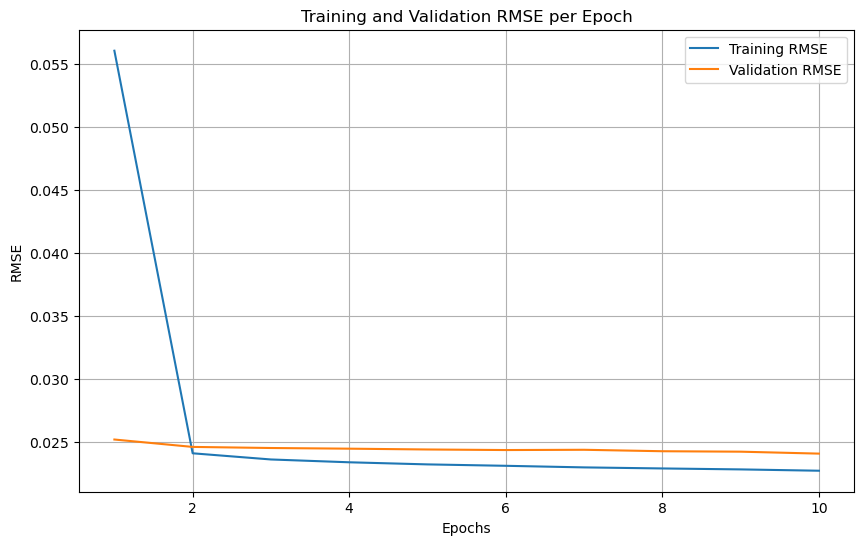

In [17]:
# Graficar pérdidas
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_summaries, label='Training RMSE')
plt.plot(epochs_range, valid_summaries, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE per Epoch')
plt.legend()
plt.grid(True)
image_name = f'rmse_per_epoch_modelo_npix{npix}_ntn{ntn}_nv{nv}_ntt{ntt}_b{batch_size}_ts{steps}_{opti}_tf_deep_drop.png'
plt.savefig(image_name) 
plt.show()

In [18]:
def plotImage(image_data):
    plt.figure()
    plt.imshow(image_data, cmap='magma')
    plt.colorbar()
    plt.title('Imagen FITS')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.gca().invert_yaxis() 
    plt.savefig('Image-disk-tf.png')
    plt.show()

def plotVelocity(v_real, v_model, pix):

    x = np.linspace(0, pix, pix)
    y = np.linspace(0, pix, pix)
    X, Y = np.meshgrid(x, y)
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(X, Y, v_real, cmap='magma')
    plt.colorbar(label='Velocidad FARGO3D')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Componente de Velocidad según FARGO3D')
    
    plt.subplot(1, 2, 2)
    plt.pcolormesh(X, Y, v_model, cmap='magma')
    plt.colorbar(label='Velocidad Model')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Componente de Velocidad según Model')
    
    plt.tight_layout()
    plt.savefig('Velocity-result-comparison-tf.png')
    plt.show()

In [19]:
# Cargar el modelo entrenado
npix = 300
opti = 'Adam'
ntn = len(train_images)
nv = len(valid_images)
ntt = len(test_images)
model_name = f'modelo_npix{npix}_ntn{ntn}_nv{nv}_ntt{ntt}_b{batch_size}_ts{steps}_{opti}_deep_drop'
model = tf.keras.models.load_model(model_name)

# Definir la pérdida
criterion = MeanSquaredError()

# Configuración para la evaluación
npix = pix_prueba
all_predictions = np.empty((0, npix, npix, 1))
all_real = np.empty((0, npix, npix, 1))
all_test_images = np.empty((0, steps, npix, npix, 1))

# Evaluar el modelo y hacer predicciones
for images, velocities in test_dataset:
    predicciones = model(images, training=False)
    loss = criterion(velocities, predicciones)
    #print(loss.numpy())
    # Convertir los tensores a numpy arrays y agregar a las colecciones
    predicciones_np = predicciones.numpy()
    all_predictions = np.append(all_predictions, predicciones_np, axis=0)
    
    velocities_np = velocities.numpy()
    all_real = np.append(all_real, velocities_np, axis=0)
    
    images_np = images.numpy()
    all_test_images = np.append(all_test_images, images_np, axis=0)

# Imprimir las formas de las matrices
print(all_predictions.shape)
print(all_real.shape)
print(all_test_images.shape)

(14, 300, 300, 1)
(14, 300, 300, 1)
(14, 9, 300, 300, 1)


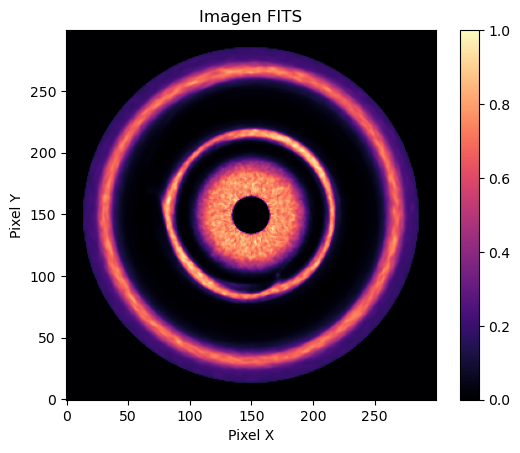

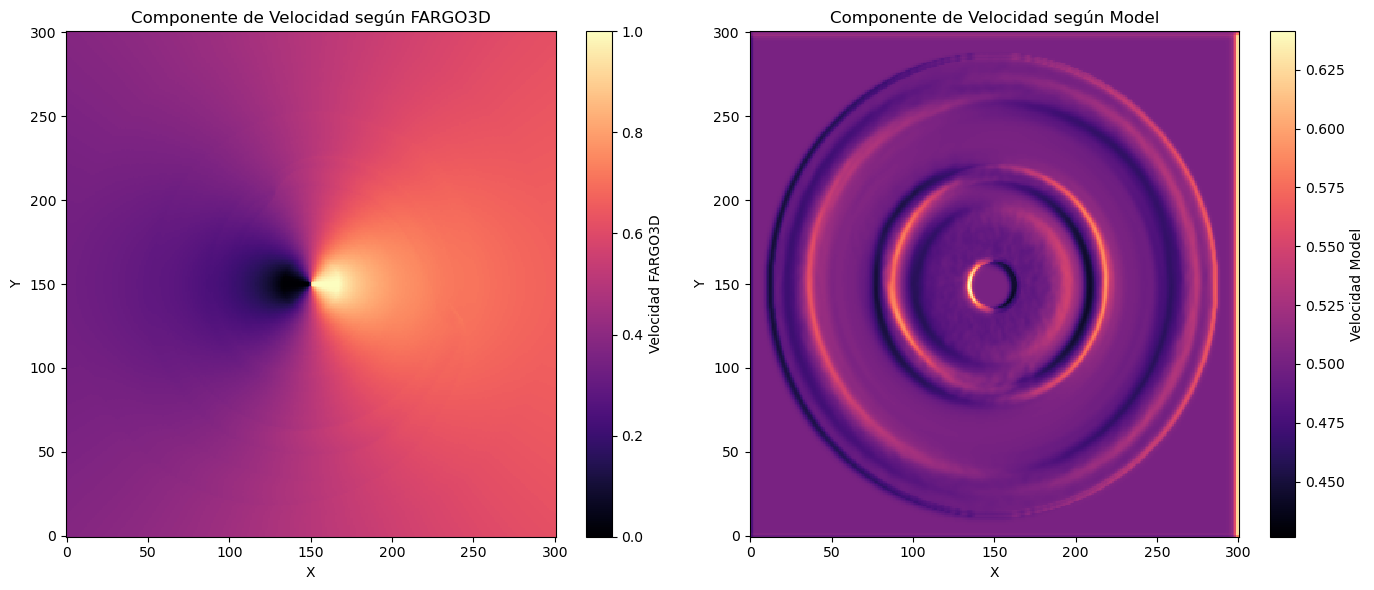

RMSE: 0.1537
MAE: 0.1332
SSIM: 0.8561
El valor de R^2 es: -15.304938234250521


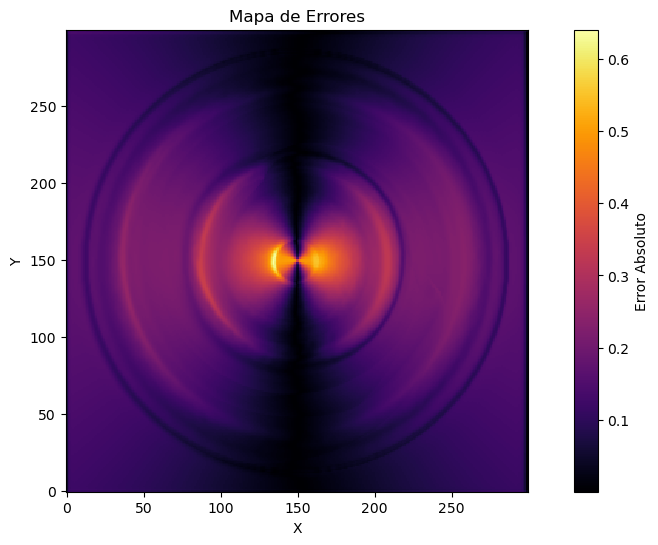

In [20]:
id = 0
plotImage(all_test_images[id][steps-1].reshape((npix, npix)))
plotVelocity(all_real[id].reshape((npix, npix)), all_predictions[id].reshape((npix,npix)), npix)
y_true = all_real[id].reshape((npix, npix))
y_pred = all_predictions[id].reshape((npix,npix))

# Calcular RMSE
mse = np.mean((y_true - y_pred) ** 2)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

# Calcular MAE
mae = np.mean(np.abs(y_true - y_pred))
print(f"MAE: {mae:.4f}")

# Calcular SSIM
from skimage.metrics import structural_similarity as ssim
ssim_index, _ = ssim(y_true, y_pred, data_range=y_true.max() - y_true.min(), full=True)
print(f"SSIM: {ssim_index:.4f}")

# Calcular el R^2
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"El valor de R^2 es: {r2}")

# Calcular el mapa de errores
error_map = np.abs(y_true - y_pred)

# Visualizar el mapa de errores
plt.figure(figsize=(12, 6))
plt.imshow(error_map, cmap='inferno', interpolation='nearest')
plt.colorbar(label='Error Absoluto')
plt.title('Mapa de Errores')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().invert_yaxis() 
plt.savefig('Error_Map.png')
plt.show()